# Time invariant analysis, with summary features

In [7]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from scipy.stats import skew, kurtosis
import soundfile as sf
from collections import defaultdict

def lda_analysis(X, Y, n_components=2):
    """Perform LDA analysis on the data

    Args:
        X (pd.DataFrame): DataFrame containing the features.
        Y (pd.Series): Series containing the labels.
        n_components (int): Number of components for LDA (min 2, max 3).
    Returns:
        X_lda (LinearDiscriminantAnalysis): Fitted LDA model.
    """
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X, Y)
    
    return X_lda, lda

def lda_multiclass_analysis(X_lda, Y):

    # Apprentissage LDA sur données projetées (optionnel si tu as déjà fit)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_lda, Y)

    # Créer un maillage 2D
    x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
    y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                        np.linspace(y_min, y_max, 300))

    # Prédiction sur la grille
    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    colors = ['red', 'orange', 'blue', 'green']

    # Affichage
    cmap_background = ListedColormap(["#FFAAAA", "#FFCC5D", "#AAAAFF", "#84DC78"])
    cmap_points = ListedColormap(["#FF0000", "#FFAE00", "#0000FF", "#36DA20"])

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, 
                 yy, 
                 Z, 
                 alpha=0.3,
                 cmap=cmap_background)

    for idx, label in enumerate(np.unique(Y)):
        plt.scatter(X_lda[Y == label, 0], 
                    X_lda[Y == label, 1], 
                    label= labels[label],
                    color=colors[label],
                    edgecolor='k',
                    s=50)

    plt.grid(True)
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.title("LDA multiclass analysis")
    plt.legend()
    plt.show()

    return lda

def get_mutual_information(X, Y, features, binary=True):

    if binary:
        Y = np.where(np.isin(Y, [0, 1]), 0, 1) # 0 si dans [0,1], 1 si dans [2,3]
    mi_score = mutual_info_classif(X, Y, discrete_features=False)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mi_score)), mi_score, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Mutual Information Score')
    plt.title('Mutual Information Scores for Features')
    plt.xticks(range(len(mi_score)), [f'{features[i]}' for i in range(len(mi_score))], rotation=90, fontsize=6)
    plt.grid(axis='y')
    plt.show()

    return

def print_lda_separation_assessement(lda, X_lda_2, Y, binary=True):

    if binary:
        target_names = ["Group 0–1", "Group 2–3"]
    else:
        target_names = ["Untrained", "Beginner", "Intermediate", "Expert"]

    Y_pred = lda.predict(X_lda_2)
    correct = np.sum(Y_pred == Y)
    total = len(Y)
    print(f"{correct}/{total} points correctement séparés ({100 * correct / total:.1f}%)")
    print("Accuracy:", accuracy_score(Y, Y_pred))
    print("Confusion matrix:\n", confusion_matrix(Y, Y_pred))
    print("Classification report:\n",
          classification_report(Y,
                                Y_pred,
                                target_names=target_names,
                                zero_division=0))  # Handle zero division if any class has no samples
    
def plot_emotion_profiles(X, Y, save_path=None):
    """Plot the emotion profiles for each expertise level

    Args:
        X (pd.DataFrame): DataFrame containing the features.
        Y (pd.Series): Series containing the labels.
        save_path (str): Path to save the plot.
    """

    Untrained_emotion_profiles = []
    Begginer_emotion_profiles = []
    Intermediate_emotion_profiles = []
    Expert_emotion_profiles = []

    for idx in X.index:
        if Y[idx] == 0:
            Untrained_emotion_profiles.append(X.T[idx][:7])
        elif Y[idx] == 1:
            Begginer_emotion_profiles.append(X.T[idx][:7])
        elif Y[idx] == 2:
            Intermediate_emotion_profiles.append(X.T[idx][:7])
        elif Y[idx] == 3:
            Expert_emotion_profiles.append(X.T[idx][:7])

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, 8), np.mean(Untrained_emotion_profiles, axis=0), label='Untrained', marker='o')
    plt.plot(np.arange(1, 8), np.mean(Begginer_emotion_profiles, axis=0), label='Begginer', marker='o')
    plt.plot(np.arange(1, 8), np.mean(Intermediate_emotion_profiles, axis=0), label='Intermediate', marker='o')
    plt.plot(np.arange(1, 8), np.mean(Expert_emotion_profiles, axis=0), label='Expert', marker='o')

    plt.xticks(np.arange(1, 8), ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise', 'neutral'])
    plt.ylabel('Mean Emotion Intensity')
    plt.title('Emotion Profiles by Expertise Level')
    plt.legend()
    plt.grid(True)
    plt.show()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    return

def plot_speech_activity(Y, verbose=False):

    expertise_levels = {"Untrained": 0, "Begginer": 1, "Intermediate": 2, "Expert": 3}
    expertise_levels_inverse = {v: k for k, v in expertise_levels.items()}

    Untrained_speech_activity = []
    Begginer_speech_activity = []
    Intermediate_speech_activity = []
    Expert_speech_activity = []

    for idx in X.index:
        if Y[idx] == 0:
            Untrained_speech_activity.append(X.T[idx][7])
        elif Y[idx] == 1:
            Begginer_speech_activity.append(X.T[idx][7])
        elif Y[idx] == 2:
            Intermediate_speech_activity.append(X.T[idx][7])
        elif Y[idx] == 3:
            Expert_speech_activity.append(X.T[idx][7])

    if verbose:
        print(f'Untrained speech activity: {np.mean(Untrained_speech_activity)}'
            f' ± {np.std(Untrained_speech_activity)}')
        print(f'Begginer speech activity: {np.mean(Begginer_speech_activity)}'
            f' ± {np.std(Begginer_speech_activity)}')
        print(f'Intermediate speech activity: {np.mean(Intermediate_speech_activity)}'
            f' ± {np.std(Intermediate_speech_activity)}')
        print(f'Expert speech activity: {np.mean(Expert_speech_activity)}'
            f' ± {np.std(Expert_speech_activity)}')

    # violin plot
    plt.figure(figsize=(10, 6))
    plt.violinplot([Untrained_speech_activity, Begginer_speech_activity,
                    Intermediate_speech_activity, Expert_speech_activity],
                showmeans=True)

    plt.xticks([1, 2, 3, 4], 
            [f'Untrained ({len(Untrained_speech_activity)} subjects)', 
                f'Begginer ({len(Begginer_speech_activity)} subjects)', 
                f'Intermediate ({len(Intermediate_speech_activity)} subjects)', 
                f'Expert ({len(Expert_speech_activity)} subjects)'])
    plt.ylabel('Speech Activity ratio')
    plt.title('Speech Activity by Expertise Level')
    plt.grid(True)
    plt.show()

    return

def pca_analysis(X, n_components=2):
    """Perform PCA analysis on the data

    Args:
        X (pd.DataFrame): DataFrame containing the features.
        n_components (int): Number of principal components (min 2, max 3).
    Returns:
        X_pca (np.ndarray): Transformed data in PCA space.
        pca (PCA): Fitted PCA object.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    return X_pca, pca

def knn_multiclass_analysis(X_2D, Y, projection = None):
    # Créer un maillage 2D
    x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
    y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Classifieur simple (optionnel) pour illustrer une séparation
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_2D[:, :2], Y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    colors = ['red', 'orange', 'blue', 'green']

    cmap_background = ListedColormap(["#FFAAAA", "#FFCC5D", "#AAAAFF", "#84DC78"])
    cmap_points = ListedColormap(["#FF0000", "#FFAE00", "#0000FF", "#36DA20"])

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)

    for idx, label in enumerate(np.unique(Y)):
        plt.scatter(X_2D[Y == label, 0],
                    X_2D[Y == label, 1],
                    label=labels[label],
                    color=colors[label],
                    edgecolor='k',
                    s=50)

    plt.grid(True)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"{projection} + KNN classification map")
    plt.legend()
    plt.show()

    return clf

def gmm_multiclass_analysis(X_2D, Y, projection = None, n_clusters=4):
    # Grille pour affichage
    x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
    y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Classification par GMM
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    gmm.fit(X_2D)
    Z = gmm.predict(grid).reshape(xx.shape)
    cluster_pred = gmm.predict(X_2D)

    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    colors = ['#FF0000', '#FFAE00', '#0000FF', '#36DA20']
    cmap_background = ListedColormap(["#FFAAAA", "#FFCC5D", "#AAAAFF", "#84DC78"])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)

    # Tracer les ellipses de covariance GMM
    for i in range(n_clusters):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]
        plot_cov_ellipse(mean, cov, ax, color=colors[i % len(colors)], alpha=0.4)

    # Tracer les points vrais (Y)
    for idx, label in enumerate(np.unique(Y)):
        ax.scatter(X_2D[Y == label, 0],
                   X_2D[Y == label, 1],
                   label=labels[label],
                   color=colors[label],
                   edgecolor='k',
                   s=50)

    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_title(f" {projection} + GMM classification map")
    ax.grid(True)
    ax.legend()
    plt.show()

    return gmm

def print_pca_separation_assessment(classifier, X_pca, Y, binary=True):

    if binary:
        target_names = ["Group 0–1", "Group 2–3"]
    else:
        target_names = ["Untrained", "Beginner", "Intermediate", "Expert"]

    Y_pred = classifier.predict(X_pca)
    correct = np.sum(Y_pred == Y)
    total = len(Y)

    print(f"{correct}/{total} points correctement classés ({100 * correct / total:.1f}%)")
    print("Accuracy:", accuracy_score(Y, Y_pred))
    print("Confusion matrix:\n", confusion_matrix(Y, Y_pred))
    print("Classification report:\n",
          classification_report(Y, Y_pred, target_names=target_names, zero_division=0))

def plot_cov_ellipse(mean, cov, ax, color, alpha=0.3, n_std=2.0):
    """Trace une ellipse de covariance 2D."""
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      edgecolor=color, fc=color, lw=2, alpha=alpha)
    ax.add_patch(ellipse)

def covariance_ellipses(X_2D, Y, projection = None):

    # Grille
    x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
    y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    colors = ['red', 'orange', 'blue', 'green']
    cmap_points = ListedColormap(["#FF0000", "#FFAE00", "#0000FF", "#36DA20"])

    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, label in enumerate(np.unique(Y)):
        X_class = X_2D[Y == label]
        ax.scatter(X_class[:, 0], X_class[:, 1],
                   color=colors[label], label=labels[label],
                   edgecolor='k', s=50)

        # Moyenne et covariance
        mean = X_class.mean(axis=0)
        cov = np.cov(X_class, rowvar=False)
        plot_cov_ellipse(mean, cov, ax, color=colors[label], alpha=0.3)

    if projection == "lda":
        ax.set_title("LDA Projection Covariance ellipses")
    elif projection == "pca":
         ax.set_title("PCA Projection Covariance ellipses")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True)
    ax.legend()
    plt.show()

    return 



In [8]:
# Extracting features code

def get_duration_soundfile(path):
    with sf.SoundFile(path) as f:
        duration = len(f) / f.samplerate
    return duration

def emo_features(emo_array, 
                 start_time,
                 analysis_duration):

    start_frame = int(start_time / 1.5)
    frames = int(analysis_duration / 1.5)
    emo_array_cut = emo_array[start_frame:start_frame + frames]  # shape: (7, frames)
    emo_array_cut = np.array(emo_array_cut).T

    stats = []
    for i in range(emo_array_cut.shape[0]):  # For each of the 7 dimensions
        emo_values = emo_array_cut[i]
        non_zero = emo_values[emo_values > 0]
        # non_zero = emo_values

        if len(non_zero) > 0:
            mean = np.mean(non_zero)
            std = np.std(non_zero)
            skewness = skew(non_zero)
            kurt = kurtosis(non_zero)
            min_val = np.min(non_zero)
            max_val = np.max(non_zero)
            median = np.median(non_zero)
        else:
            mean = std = skewness = kurt = min_val = max_val = median = 1e-5

        stats.extend([mean, std, skewness, kurt, min_val, max_val, median])

    return np.array(stats)

def f0_features(f0_array,
                start_time,
                analysis_duration):
    
    start_frame = int(start_time/0.01)
    frames = int(analysis_duration/0.01)
    f0_array = f0_array[start_frame:start_frame + frames]

    nonzero_f0 = f0_array[f0_array > 0]
    voiced_ratio = len(nonzero_f0) / len(f0_array) if len(f0_array) > 0 else 0

    if len(nonzero_f0) > 0:
        mean = np.mean(nonzero_f0)
        std = np.std(nonzero_f0)
        skewness = skew(nonzero_f0)
        kurt = kurtosis(nonzero_f0)
        f0_min = np.min(nonzero_f0)
        f0_max = np.max(nonzero_f0)
        f0_median = np.median(nonzero_f0)
    else:
        mean = std = skewness = kurt = f0_min = f0_max = f0_median = 0

    return np.array([
        mean,
        std,
        voiced_ratio,
        skewness,
        kurt,
        f0_min,
        f0_max,
        f0_median
    ])

def nrj_features(nrj_array,
                 start_time,
                 analysis_duration):
    """
    nrj_array: 1D array of energy values
    Compute:
    - mean energy
    - std energy
    - max energy
    """

    start_frame = int(start_time/0.01)
    frames = int(analysis_duration/0.01)
    nrj_array = nrj_array[start_frame:start_frame + frames]
    
    mean = np.mean(nrj_array)
    std = np.std(nrj_array)
    max = np.max(nrj_array)

    return np.array([
        mean,
        std,
        max
    ])

def extract_features(features_to_extract,
                     dir_path,
                     file_name,
                     start_time,
                     analysis_duration,
                     emotion_model = "20250526-120449",
                     pondered_outputs = True):
    
    """
    features_to_extract: list of features to compute (e.g. ['emo', 'f0', 'nrj'])
    dir_path: string, path to the directory
    file_name: string, name of the file
    analysis_duration: float (in seconds), e.g., 15
    path: string, path to the folder containing features (emo.npy, f0.npy, nrj.npy)

    Returns concatenated feature vector
    """

    assert analysis_duration % 1.5 == 0

    audio_path = os.path.join(dir_path, file_name + ".wav")
    audio_duration = get_duration_soundfile(audio_path)

    if start_time >= audio_duration - analysis_duration - 1.5:
        start_time = (audio_duration - analysis_duration)
        start_time = start_time - start_time % 1.5 - 1.5
        # print(f'start time {start_time}')

    assert start_time % 1.5 == 0

    final_vector = []

    if 'emo' in features_to_extract:
        if pondered_outputs:
            emo_path = os.path.join(dir_path, "emotion", emotion_model, file_name + "_pondered_outputs.pt")
        else:
            emo_path = os.path.join(dir_path, "emotion", emotion_model, file_name + "_outputs.pt")
        emo_array = torch.load(emo_path)
        emo_array_component = emo_features(emo_array, start_time, analysis_duration)
        final_vector.append(emo_array_component)

    if 'f0' in features_to_extract:
        try:
            f0_path = os.path.join(dir_path, "humavox_features", file_name + ".16k.f0")
            f0_array = np.loadtxt(f0_path)[:,1]
            f0_array_components = f0_features(f0_array, start_time, analysis_duration)
            final_vector.append(f0_array_components)
        except:
            f0_path = os.path.join(dir_path, "humavox_features", file_name + ".f0")
            f0_array = np.loadtxt(f0_path)[:,1]
            f0_array_components = f0_features(f0_array, start_time, analysis_duration)
            final_vector.append(f0_array_components)   

    if 'nrj' in features_to_extract:
        try:
            nrj_path = os.path.join(dir_path, "humavox_features", file_name + ".16k.nrj")
            nrj_array = np.loadtxt(nrj_path)[:,1]
            nrj_array_components = nrj_features(nrj_array, start_time, analysis_duration)
            final_vector.append(nrj_array_components)
        except:
            nrj_path = os.path.join(dir_path, "humavox_features", file_name + ".nrj")
            nrj_array = np.loadtxt(nrj_path)[:,1]
            nrj_array_components = nrj_features(nrj_array, start_time, analysis_duration)
            final_vector.append(nrj_array_components) 

    return np.concatenate(final_vector)  # final shape depends on selected features

def generate_start_times(audio_duration, analysis_duration, step=1.5):
    """
    Generate start times for analysis windows

    Args:
        audio_duration (int or float): Total duration of the audio in seconds.
        analysis_duration (int or float): Duration of each analysis window.
        step (float): Temporal granularity of the windows (default is 1.5 s).

    Returns:
        List[float]: List of start times for the analysis windows.
    """

    n_windows = int(audio_duration // analysis_duration) + 1
    possible_starts = np.arange(0, audio_duration - analysis_duration, step)

    if n_windows > len(possible_starts):
        raise ValueError("Durée d'audio trop courte")

    indices = np.linspace(0, len(possible_starts) - 1, n_windows).astype(int)
    start_times = possible_starts[indices]

    return start_times.tolist()

def get_feature_vectors(metadata_filepath,
                        emotion_model = "20250526-120449",
                        task = "boutonnage",
                        analysis_duration = 15,
                        features_to_extract = ['emo', 'f0', 'nrj'],
                        pondered_outputs = True):

    metadata = pd.read_csv(metadata_filepath)
                        
    expertise_levels = {"Untrained": 0, "Begginer": 1, "Intermediate": 2, "Expert": 3}

    X = [] # Features
    Y = [] # Labels

    for _ , row in metadata.iterrows():
        dir_path = row['dir_path']
        filename = row['filename']
        audio_filepath = os.path.join(dir_path, filename + ".wav")
        task = row['task']
        level = row['level']

        if task == "boutonnage":
            label = expertise_levels[level]

            audio_duration = get_duration_soundfile(audio_filepath)
            # print(f'audio filepath : {audio_filepath}')
            start_times = generate_start_times(audio_duration, analysis_duration)

            for start_time in start_times:
                features_vector = extract_features(features_to_extract, 
                                                dir_path, 
                                                filename, 
                                                start_time, 
                                                analysis_duration,
                                                emotion_model,
                                                pondered_outputs)
                
                X.append(features_vector.tolist())
                Y.append(label)

    X = pd.DataFrame(X)
    Y = pd.Series(Y)

    return X, Y

def create_kfolds(all_individuals, k=6, random_state=42):
    # Initialiser KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    # Distribuer les individus dans les folds
    folds = []
    for train_index, test_index in kf.split(all_individuals):
        train_fold = [all_individuals[i] for i in train_index]
        test_fold = [all_individuals[i] for i in test_index]
        folds.append((train_fold, test_fold))

    return folds

def get_feature_vectors_fold(fold,
                             metadata_filepath,
                             emotion_model = "20250526-120449",
                             task = "boutonnage",
                             analysis_duration = 15,
                             features_to_extract = ['emo', 'f0', 'nrj'],
                             pondered_outputs = True):

    metadata = pd.read_csv(metadata_filepath)
                        
    expertise_levels = {"Untrained": 0, "Begginer": 1, "Intermediate": 2, "Expert": 3}

    X = [] # Features
    Y = [] # Labels

    for _ , row in metadata.iterrows():
        dir_path = row['dir_path']
        filename = row['filename']
        audio_filepath = os.path.join(dir_path, filename + ".wav")
        task = row['task']
        level = row['level']
        speaker = row['speaker']

        if task == "boutonnage" and speaker in fold:
            label = expertise_levels[level]

            audio_duration = get_duration_soundfile(audio_filepath)
            start_times = generate_start_times(audio_duration, analysis_duration)

            for start_time in start_times:
                features_vector = extract_features(features_to_extract, 
                                                dir_path, 
                                                filename, 
                                                start_time, 
                                                analysis_duration,
                                                emotion_model,
                                                pondered_outputs)
                
                X.append(features_vector.tolist())
                Y.append(label)

    X = pd.DataFrame(X)
    Y = pd.Series(Y)

    return X, Y

def plot_knn_with_test_data(X_2D_train, Y_train, X_2D_test, Y_test, projection=None, save=None):
    # Combiner les données d'entraînement et de test pour déterminer les limites du maillage
    X_combined = np.vstack((X_2D_train, X_2D_test))

    # Créer un maillage 2D
    x_min, x_max = X_combined[:, 0].min() - 1, X_combined[:, 0].max() + 1
    y_min, y_max = X_combined[:, 1].min() - 1, X_combined[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    # Classifieur KNN
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_2D_train, Y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Prédire les classes des points de test
    Y_test_pred = clf.predict(X_2D_test)

    # Calculer les performances de classification
    accuracy = accuracy_score(Y_test, Y_test_pred)
    # precision = precision_score(Y_test, Y_test_pred, average='weighted')
    # recall = recall_score(Y_test, Y_test_pred, average='weighted')
    # f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    colors = ['red', 'orange', 'blue', 'green']

    cmap_background = ListedColormap(["#FFAAAA", "#FFCC5D", "#AAAAFF", "#84DC78"])
    cmap_points = ListedColormap(["#FF0000", "#FFAE00", "#0000FF", "#36DA20"])

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)

    # Tracer les points d'entraînement
    for idx, label in enumerate(np.unique(Y_train)):
        plt.scatter(X_2D_train[Y_train == label, 0], X_2D_train[Y_train == label, 1],
                    label=f"{labels[label]} (Train)", color=colors[idx], edgecolor='k', s=50)

    # Tracer les points de test avec leurs vraies étiquettes
    for idx, label in enumerate(np.unique(Y_test)):
        plt.scatter(X_2D_test[Y_test == label, 0], X_2D_test[Y_test == label, 1],
                    label=f"{labels[label]} (Test)", color=colors[idx], edgecolor='k', s=50, marker='x')

    plt.grid(True)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"{projection} + KNN classification map with Test Data")
    plt.legend()
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    plt.show()
    plt.close()

    return {
        'accuracy': accuracy,
        # 'precision': precision,
        # 'recall': recall,
        # 'f1': f1,
        'classification_report': classification_report(Y_test, Y_test_pred, output_dict=True)
    }

def plot_knn_with_test_data(X_2D_train, Y_train, X_2D_test, Y_test, projection=None, save=None):
    # Combine for mesh boundaries
    X_combined = np.vstack((X_2D_train, X_2D_test))
    x_min, x_max = X_combined[:, 0].min() - 1, X_combined[:, 0].max() + 1
    y_min, y_max = X_combined[:, 1].min() - 1, X_combined[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    # Train KNN classifier
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_2D_train, Y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    Y_test_pred = clf.predict(X_2D_test)

    accuracy = accuracy_score(Y_test, Y_test_pred)

    # Label mapping
    labels = ['Untrained', 'Beginner', 'Intermediate', 'Expert']
    label_to_color = {
        0: 'red',        # Untrained
        1: 'orange',     # Beginner
        2: 'blue',       # Intermediate
        3: 'green'       # Expert
    }
    background_colors = {
        0: '#FFAAAA',
        1: '#FFCC5D',
        2: '#AAAAFF',
        3: '#84DC78'
    }

    # Create background colormap with fixed order
    cmap_background = ListedColormap([background_colors[i] for i in range(4)])

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)

    # Plot training data
    for label in range(4):
        mask = Y_train == label
        if np.any(mask):
            plt.scatter(X_2D_train[mask, 0], X_2D_train[mask, 1],
                        label=f"{labels[label]} (Train)", 
                        color=label_to_color[label], 
                        edgecolor='k', s=50)

    # Plot test data
    for label in range(4):
        mask = Y_test == label
        if np.any(mask):
            plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],
                        label=f"{labels[label]} (Test)", 
                        color=label_to_color[label], 
                        edgecolor='k', s=50, marker='x')

    plt.grid(True)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"{projection} + KNN classification map with Test Data")
    plt.legend()
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    plt.show()
    plt.close()

    return {
        'accuracy': accuracy,
        'classification_report': classification_report(Y_test, Y_test_pred, output_dict=True)
    }

def aggregate_classification_reports(results):
    # Initialiser des dictionnaires pour stocker les métriques agrégées
    aggregated_report = defaultdict(lambda: defaultdict(list))

    # Parcourir les résultats de chaque fold
    for result in results:
        report = result['classification_report']
        for class_label in report:
            if class_label in ['accuracy', 'macro avg', 'weighted avg']:
                continue  # Ignorer les moyennes globales pour l'instant
            for metric in report[class_label]:
                if metric != 'support':
                    aggregated_report[class_label][metric].append(report[class_label][metric])

    # Calculer la moyenne des métriques pour chaque classe
    for class_label in aggregated_report:
        for metric in aggregated_report[class_label]:
            aggregated_report[class_label][metric] = sum(aggregated_report[class_label][metric]) / len(aggregated_report[class_label][metric])

    return dict(aggregated_report)


## Test on custom fold

X shape: (152, 60), Y shape: (152,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


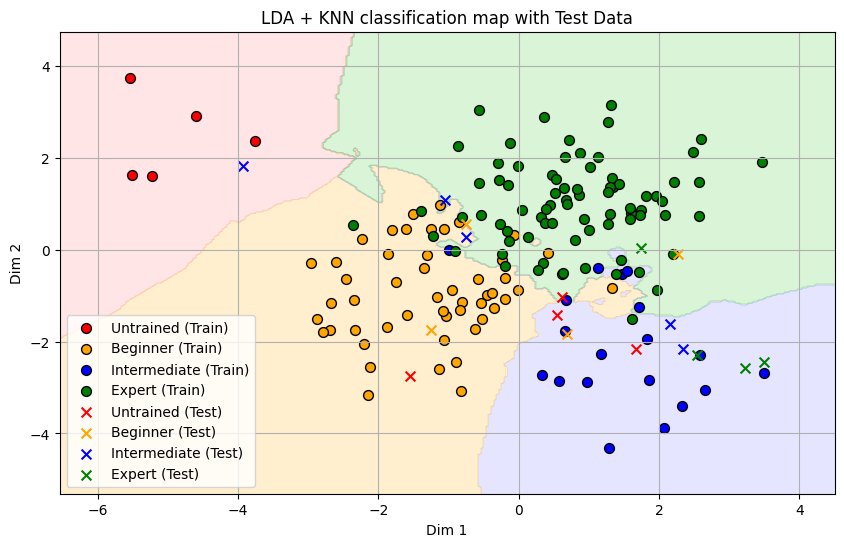

In [9]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 30
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

train_fold = ['p007', 'p003', 'p004', 'p005', 'p011', 'p014', 
              'p019', 'p020', 'p023', 'p010', 'p017', 'p022', 
              'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

test_fold = ['p002', 'p001', 'p009', 'p006']

X, Y = get_feature_vectors_fold(train_fold,
                                metadata_filepath,
                                emotion_model,
                                task,
                                analysis_duration,
                                features_to_extract,
                                pondered_outputs)

X_test, Y_test = get_feature_vectors_fold(test_fold,
                                          metadata_filepath,
                                          emotion_model,
                                          task,
                                          analysis_duration,
                                          features_to_extract,
                                          pondered_outputs)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

### LDA analysis
X_lda, lda = lda_analysis(X, Y, n_components=2)
X_test_lda = lda.transform(X_test)

result = plot_knn_with_test_data(X_lda, Y, X_test_lda, Y_test, projection="LDA", save=None)



In [10]:
result['classification_report']

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0},
 '1': {'precision': 0.3333333333333333,
  'recall': 0.25,
  'f1-score': 0.2857142857142857,
  'support': 4.0},
 '2': {'precision': 0.25,
  'recall': 0.4,
  'f1-score': 0.3076923076923077,
  'support': 5.0},
 '3': {'precision': 0.2,
  'recall': 0.25,
  'f1-score': 0.2222222222222222,
  'support': 4.0},
 'accuracy': 0.23529411764705882,
 'macro avg': {'precision': 0.1958333333333333,
  'recall': 0.225,
  'f1-score': 0.2039072039072039,
  'support': 17.0},
 'weighted avg': {'precision': 0.19901960784313721,
  'recall': 0.23529411764705882,
  'f1-score': 0.21001221001221002,
  'support': 17.0}}

# K-fold cross validation on the dataset

In [11]:
### K-fold cross-validation

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert
labels = ['untrained'] * len(list_untrained) + ['beginner'] * len(list_beginner) + ['intermediate'] * len(list_intermediate) + ['expert'] * len(list_expert)

# create folds
folds = create_kfolds(all_individuals)

### 30 seconds analysis

X shape: (143, 60), Y shape: (143,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


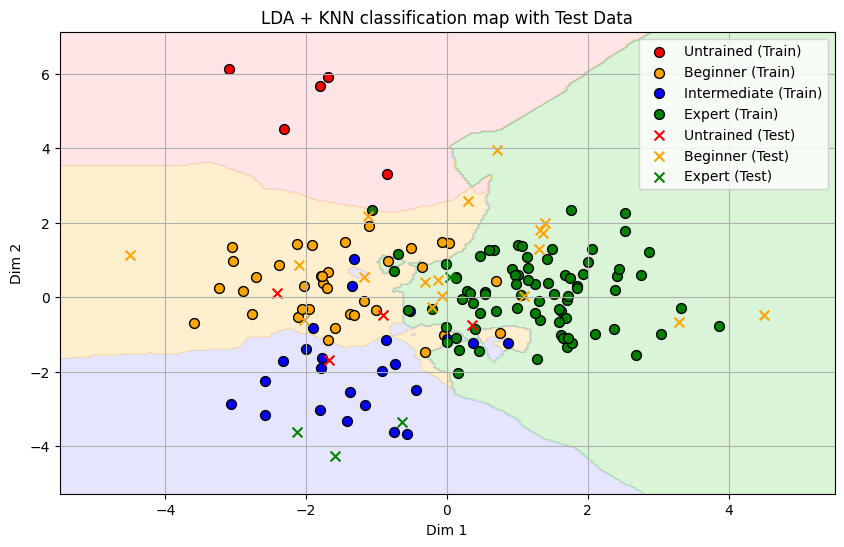

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-pa

Fold 0 accuracy: 0.23
macro : {'precision': 0.19642857142857142, 'recall': 0.13194444444444445, 'f1-score': 0.12777777777777777, 'support': 26.0}
score detail : 6 / 26
X shape: (145, 60), Y shape: (145,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


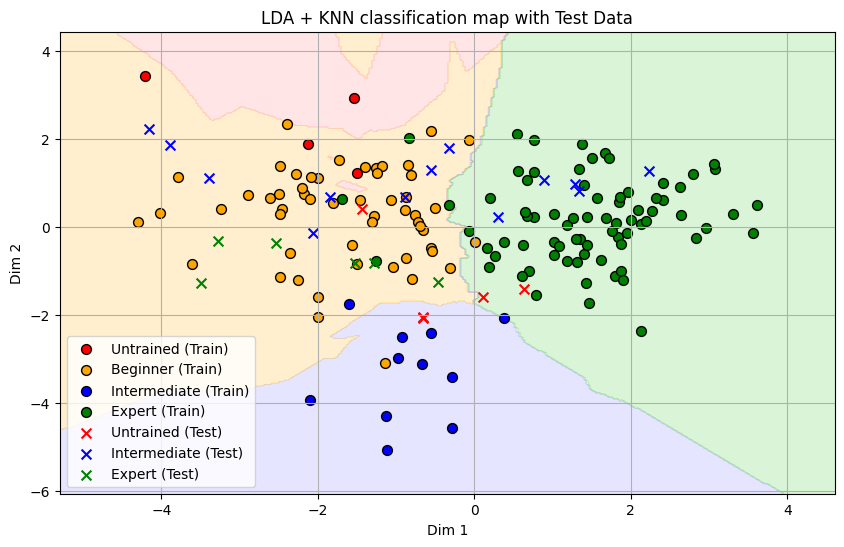

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-pa

Fold 1 accuracy: 0.00
macro : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24.0}
score detail : 0 / 24
X shape: (142, 60), Y shape: (142,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


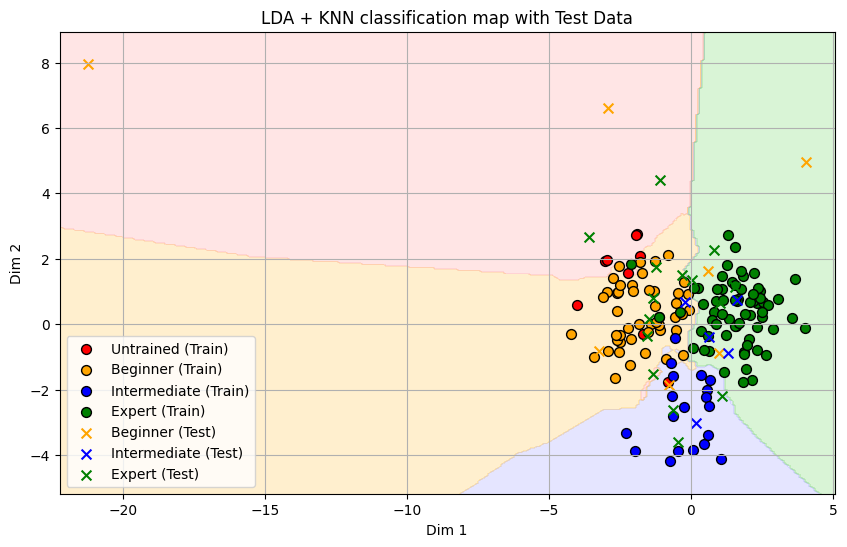

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 2 accuracy: 0.22
macro : {'precision': 0.18125000000000002, 'recall': 0.1523809523809524, 'f1-score': 0.16333333333333333, 'support': 27.0}
score detail : 6 / 27
X shape: (144, 60), Y shape: (144,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


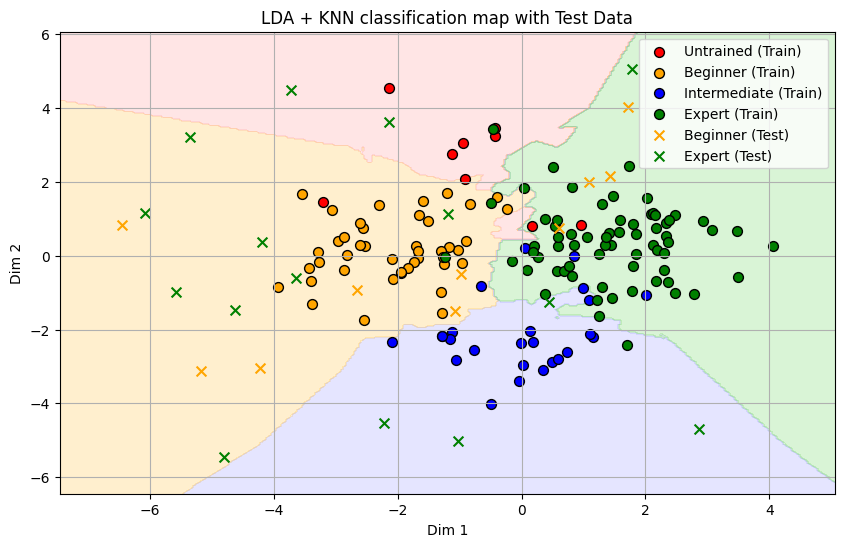

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 3 accuracy: 0.28
macro : {'precision': 0.15714285714285714, 'recall': 0.16666666666666666, 'f1-score': 0.15, 'support': 25.0}
score detail : 7 / 25
X shape: (131, 60), Y shape: (131,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


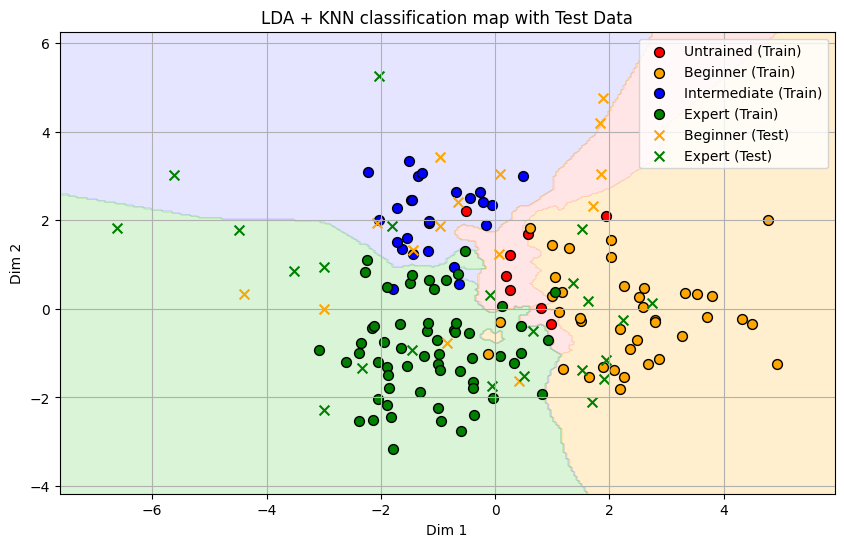

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 4 accuracy: 0.29
macro : {'precision': 0.20357142857142857, 'recall': 0.12536231884057972, 'f1-score': 0.15513513513513513, 'support': 38.0}
score detail : 11 / 38
X shape: (140, 60), Y shape: (140,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


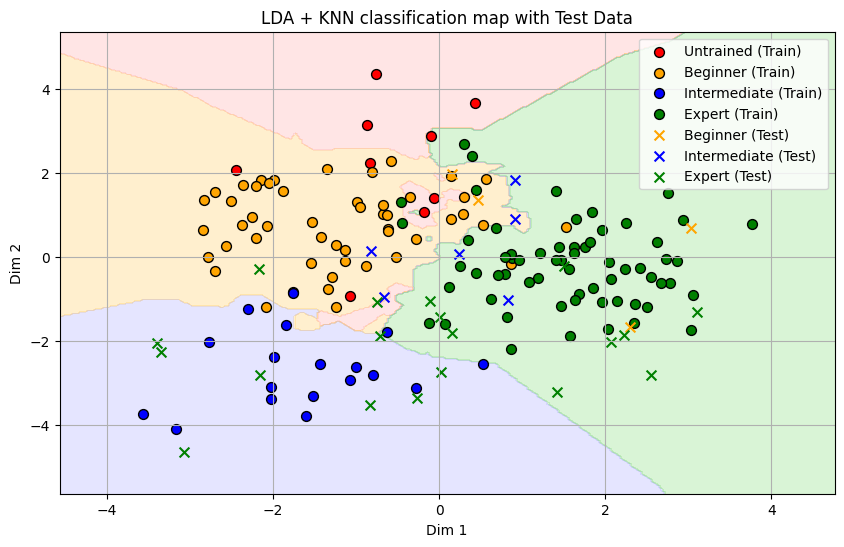

Fold 5 accuracy: 0.38
macro : {'precision': 0.30952380952380953, 'recall': 0.3245614035087719, 'f1-score': 0.30303030303030304, 'support': 29.0}
score detail : 11 / 29
total accuracy : 41 / 169 = 0.24260355029585798


In [12]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 30
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

correct_guesses = 0
support = 0

# TODO: boucle for sur les folds + option save dans plot_knn_with_test_data

for index, fold in enumerate(folds):
    train_fold, test_fold = fold

    X, Y = get_feature_vectors_fold(train_fold,
                                    metadata_filepath,
                                    emotion_model,
                                    task,
                                    analysis_duration,
                                    features_to_extract,
                                    pondered_outputs)

    X_test, Y_test = get_feature_vectors_fold(test_fold,
                                            metadata_filepath,
                                            emotion_model,
                                            task,
                                            analysis_duration,
                                            features_to_extract,
                                            pondered_outputs)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")

    ### LDA analysis
    X_lda, lda = lda_analysis(X, Y, n_components=2)
    X_test_lda = lda.transform(X_test)

    save_path = os.path.join('visualisations', 'k-fold_cross-validation', f'fold_{index}.png')

    result = plot_knn_with_test_data(X_lda, Y, X_test_lda, Y_test, projection="LDA", save=save_path)
    accuracy_fold = result['classification_report']['accuracy']
    macro = result['classification_report']['macro avg']
    support_fold = round(macro['support'])
    correct_guess = round(accuracy_fold * support_fold)
    print(f"Fold {index} accuracy: {accuracy_fold:.2f}")
    print(f"macro : {macro}")
    print(f"score detail : {correct_guess} / {support_fold}")
    correct_guesses += correct_guess
    support += support_fold

total_accuracy = correct_guesses/support
print(f'total accuracy : {correct_guesses} / {support} = {total_accuracy}')

# Get mutual information

X shape: (169, 60), Y shape: (169,)


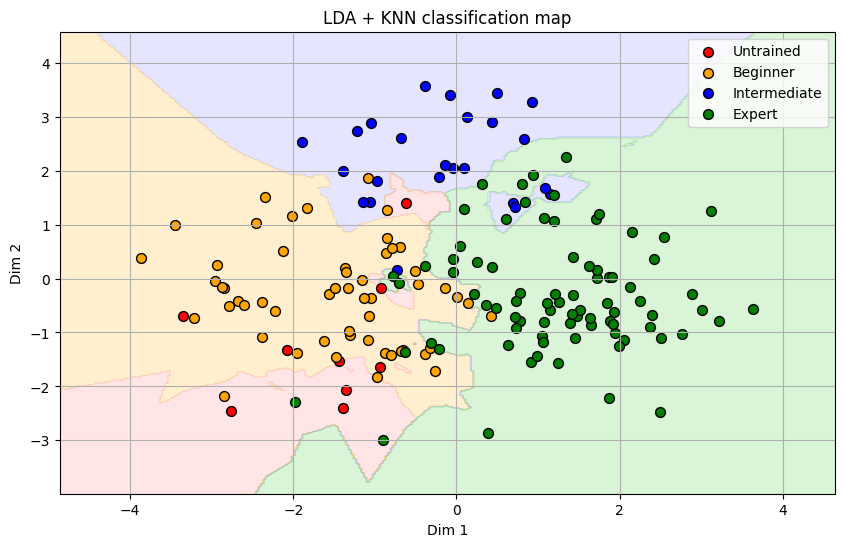

In [13]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 30
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert

X, Y = get_feature_vectors_fold(all_individuals,
                                metadata_filepath,
                                emotion_model,
                                task,
                                analysis_duration,
                                features_to_extract,
                                pondered_outputs)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

### LDA analysis
X_lda, lda = lda_analysis(X, Y, n_components=2)

knn_lda = knn_multiclass_analysis(X_lda, Y, projection = "LDA")


Number of features: 60


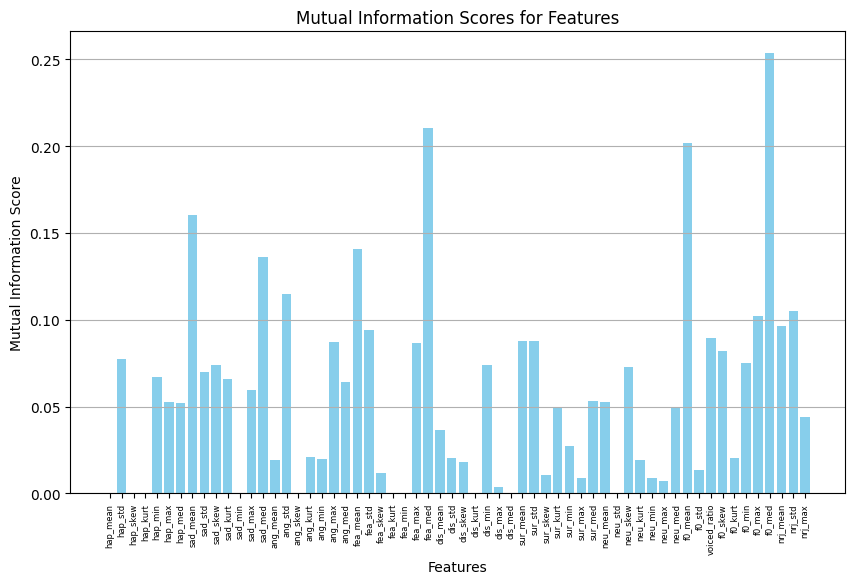

In [14]:
features = ['hap_mean', 'hap_std', 'hap_skew', 'hap_kurt', 'hap_min', 'hap_max', 'hap_med',
            'sad_mean', 'sad_std', 'sad_skew', 'sad_kurt', 'sad_min', 'sad_max', 'sad_med',
            'ang_mean', 'ang_std', 'ang_skew', 'ang_kurt', 'ang_min', 'ang_max', 'ang_med',
            'fea_mean', 'fea_std', 'fea_skew', 'fea_kurt', 'fea_min', 'fea_max', 'fea_med',
            'dis_mean', 'dis_std', 'dis_skew', 'dis_kurt', 'dis_min', 'dis_max', 'dis_med',
            'sur_mean', 'sur_std', 'sur_skew', 'sur_kurt', 'sur_min', 'sur_max', 'sur_med',
            'neu_mean', 'neu_std', 'neu_skew', 'neu_kurt', 'neu_min', 'neu_max', 'neu_med',
            'f0_mean', 'f0_std', 'voiced_ratio', 'f0_skew', 'f0_kurt', 'f0_min', 'f0_max', 'f0_med',
            'nrj_mean', 'nrj_std', 'nrj_max'
            ]

print(f"Number of features: {len(features)}")

get_mutual_information(X, Y, features, binary=False)

### 45 seconds analysis

X shape: (98, 60), Y shape: (98,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


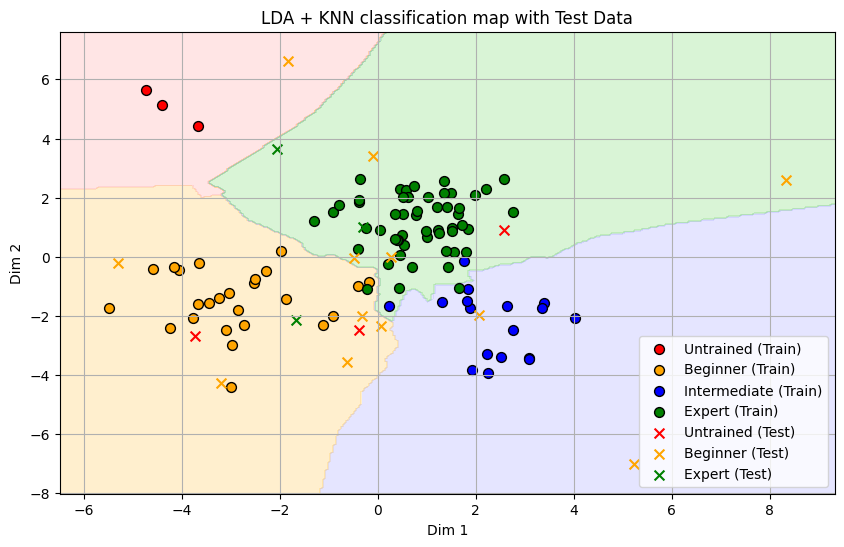

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 0 accuracy: 0.39
macro : {'precision': 0.22767857142857142, 'recall': 0.2708333333333333, 'f1-score': 0.225, 'support': 18.0}
score detail : 7 / 18
X shape: (100, 60), Y shape: (100,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


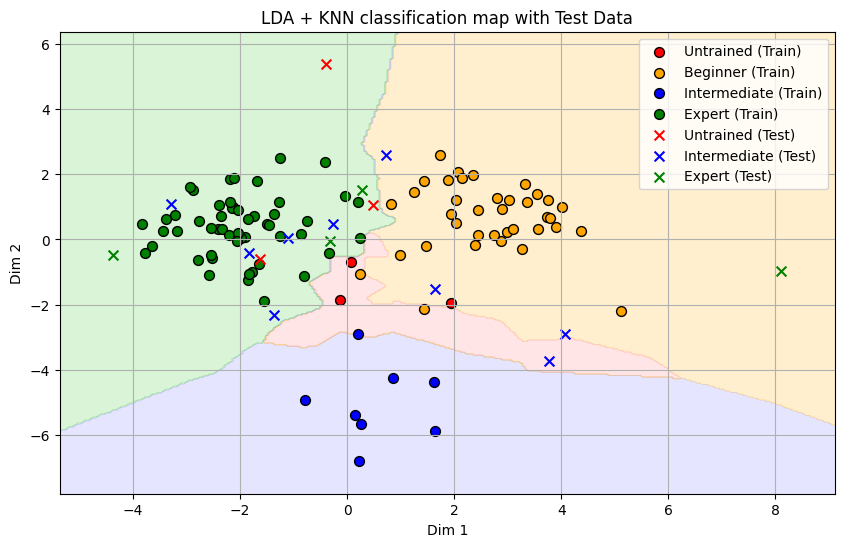

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-pa

Fold 1 accuracy: 0.19
macro : {'precision': 0.06818181818181818, 'recall': 0.1875, 'f1-score': 0.1, 'support': 16.0}
score detail : 3 / 16
X shape: (97, 60), Y shape: (97,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


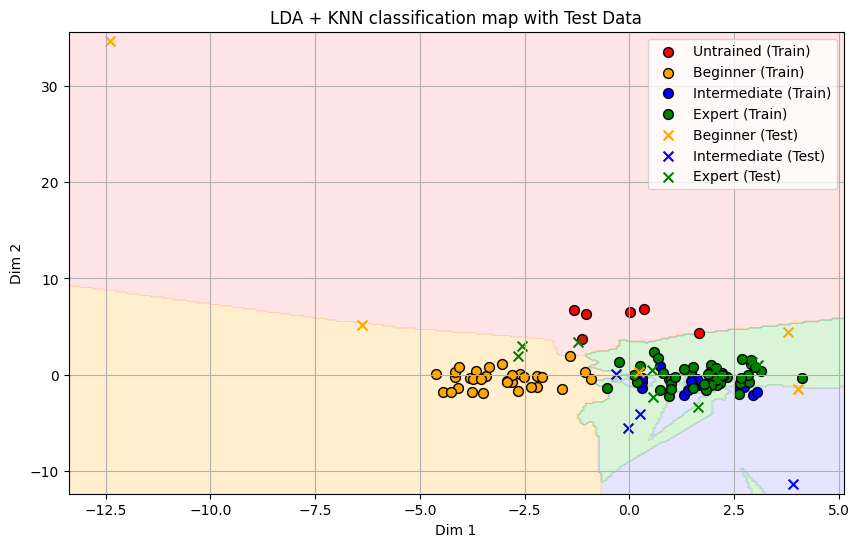

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 2 accuracy: 0.47
macro : {'precision': 0.34659090909090906, 'recall': 0.2875, 'f1-score': 0.3055555555555556, 'support': 19.0}
score detail : 9 / 19
X shape: (99, 60), Y shape: (99,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


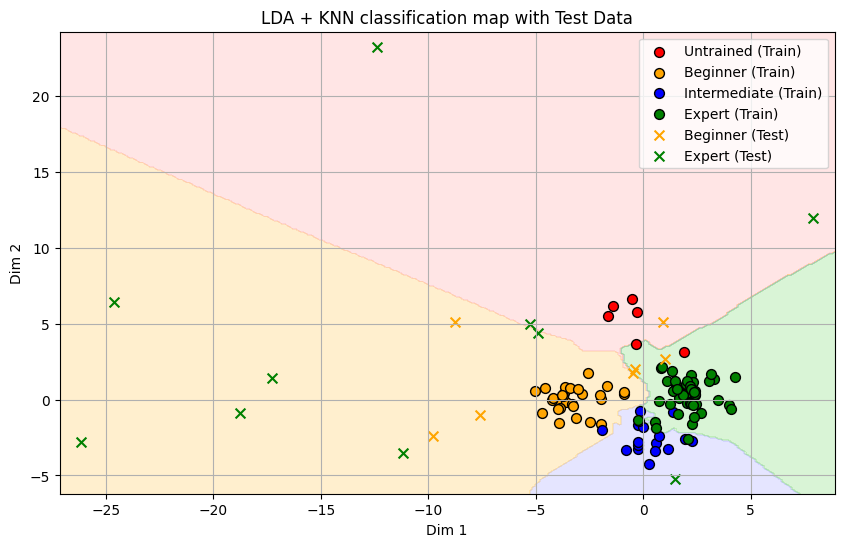

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 3 accuracy: 0.18
macro : {'precision': 0.08333333333333333, 'recall': 0.10714285714285714, 'f1-score': 0.09375, 'support': 17.0}
score detail : 3 / 17
X shape: (90, 60), Y shape: (90,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


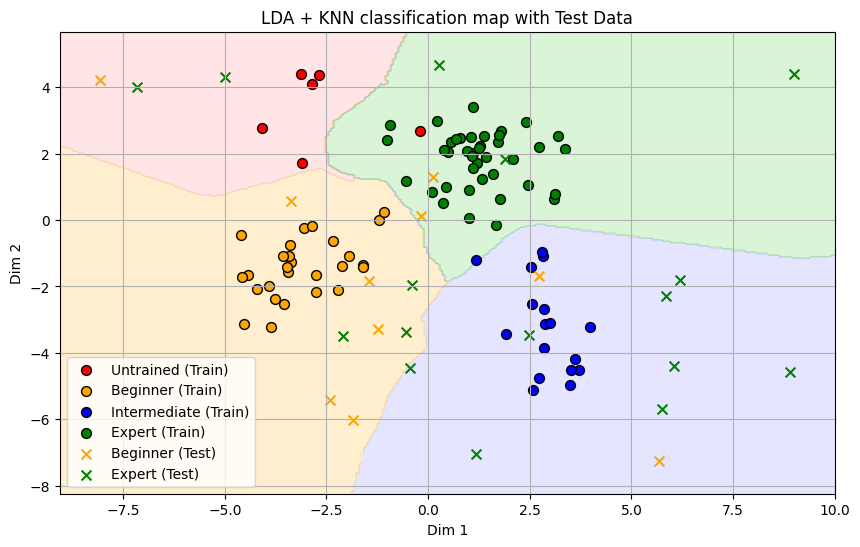

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 4 accuracy: 0.31
macro : {'precision': 0.30625, 'recall': 0.171875, 'f1-score': 0.21031746031746032, 'support': 26.0}
score detail : 8 / 26
X shape: (96, 60), Y shape: (96,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


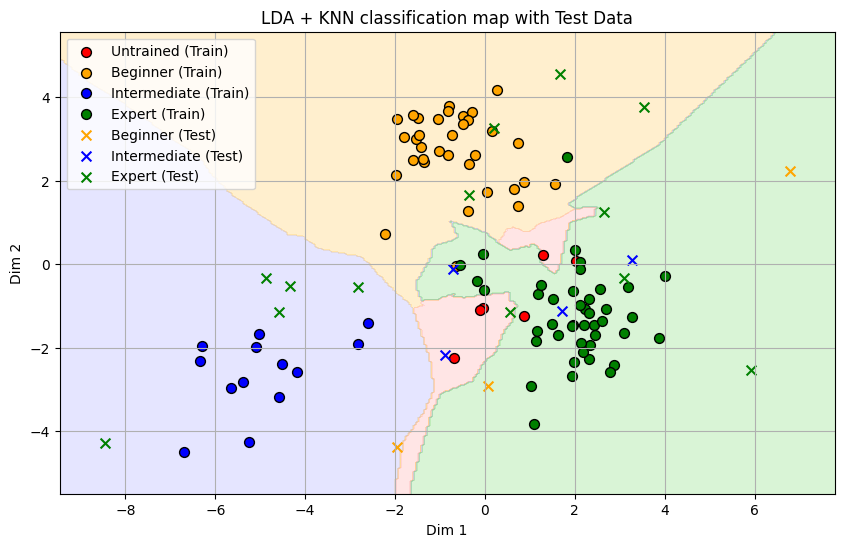

Fold 5 accuracy: 0.15
macro : {'precision': 0.09375, 'recall': 0.057692307692307696, 'f1-score': 0.07142857142857142, 'support': 20.0}
score detail : 3 / 20
total accuracy : 33 / 116 = 0.28448275862068967


/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

In [15]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 45
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

correct_guesses = 0
support = 0

for index, fold in enumerate(folds):
    train_fold, test_fold = fold

    X, Y = get_feature_vectors_fold(train_fold,
                                    metadata_filepath,
                                    emotion_model,
                                    task,
                                    analysis_duration,
                                    features_to_extract,
                                    pondered_outputs)

    X_test, Y_test = get_feature_vectors_fold(test_fold,
                                            metadata_filepath,
                                            emotion_model,
                                            task,
                                            analysis_duration,
                                            features_to_extract,
                                            pondered_outputs)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")

    ### LDA analysis
    X_lda, lda = lda_analysis(X, Y, n_components=2)
    X_test_lda = lda.transform(X_test)

    save_path = os.path.join('visualisations', 'time_invariant', f'{analysis_duration}s', f'fold_{index}.png')

    result = plot_knn_with_test_data(X_lda, Y, X_test_lda, Y_test, projection="LDA", save=save_path)
    accuracy_fold = result['classification_report']['accuracy']
    macro = result['classification_report']['macro avg']
    support_fold = round(macro['support'])
    correct_guess = round(accuracy_fold * support_fold)
    print(f"Fold {index} accuracy: {accuracy_fold:.2f}")
    print(f"macro : {macro}")
    print(f"score detail : {correct_guess} / {support_fold}")
    correct_guesses += correct_guess
    support += support_fold

total_accuracy = correct_guesses/support
print(f'total accuracy : {correct_guesses} / {support} = {total_accuracy}')


X shape: (116, 60), Y shape: (116,)


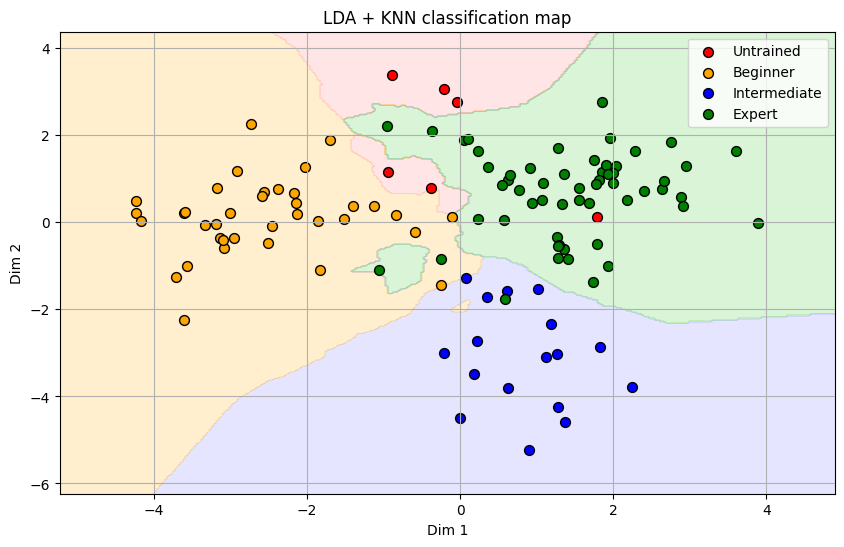

In [16]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 45
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert

X, Y = get_feature_vectors_fold(all_individuals,
                                metadata_filepath,
                                emotion_model,
                                task,
                                analysis_duration,
                                features_to_extract,
                                pondered_outputs)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

### LDA analysis
X_lda, lda = lda_analysis(X, Y, n_components=2)

knn_lda = knn_multiclass_analysis(X_lda, Y, projection = "LDA")


Number of features: 60


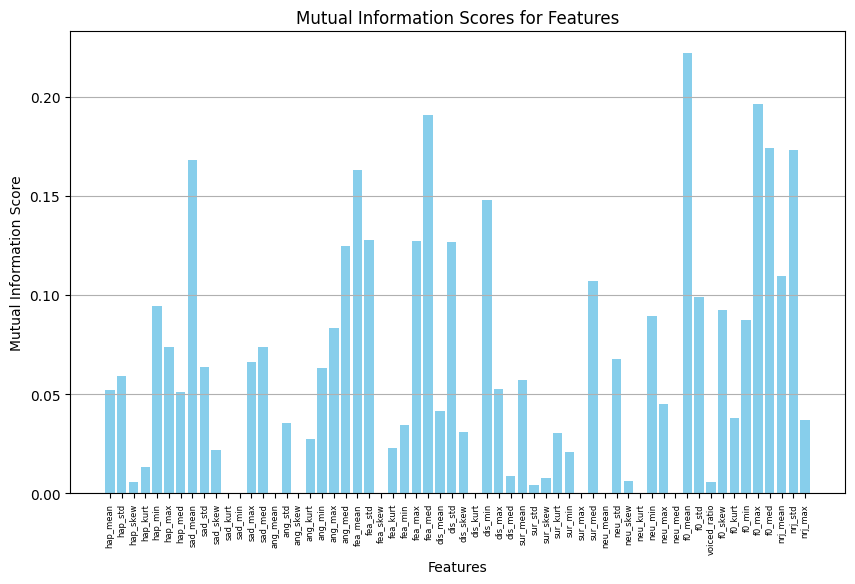

In [17]:
features = ['hap_mean', 'hap_std', 'hap_skew', 'hap_kurt', 'hap_min', 'hap_max', 'hap_med',
            'sad_mean', 'sad_std', 'sad_skew', 'sad_kurt', 'sad_min', 'sad_max', 'sad_med',
            'ang_mean', 'ang_std', 'ang_skew', 'ang_kurt', 'ang_min', 'ang_max', 'ang_med',
            'fea_mean', 'fea_std', 'fea_skew', 'fea_kurt', 'fea_min', 'fea_max', 'fea_med',
            'dis_mean', 'dis_std', 'dis_skew', 'dis_kurt', 'dis_min', 'dis_max', 'dis_med',
            'sur_mean', 'sur_std', 'sur_skew', 'sur_kurt', 'sur_min', 'sur_max', 'sur_med',
            'neu_mean', 'neu_std', 'neu_skew', 'neu_kurt', 'neu_min', 'neu_max', 'neu_med',
            'f0_mean', 'f0_std', 'voiced_ratio', 'f0_skew', 'f0_kurt', 'f0_min', 'f0_max', 'f0_med',
            'nrj_mean', 'nrj_std', 'nrj_max'
            ]

print(f"Number of features: {len(features)}")

get_mutual_information(X, Y, features, binary=False)

### 21 seconds analysis

In [18]:
### K-fold cross-validation

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert
labels = ['untrained'] * len(list_untrained) + ['beginner'] * len(list_beginner) + ['intermediate'] * len(list_intermediate) + ['expert'] * len(list_expert)

# create folds
folds = create_kfolds(all_individuals)

X shape: (232, 60), Y shape: (232,)


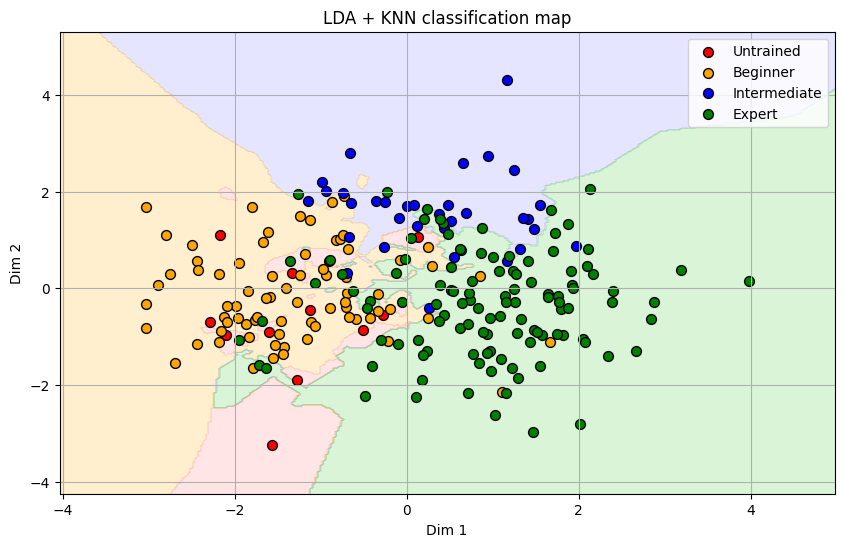

In [19]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 21
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert

X, Y = get_feature_vectors_fold(all_individuals,
                                metadata_filepath,
                                emotion_model,
                                task,
                                analysis_duration,
                                features_to_extract,
                                pondered_outputs)

X = X.fillna(0)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
# print(X)

# ### LDA analysis
X_lda, lda = lda_analysis(X, Y, n_components=2)

knn_lda = knn_multiclass_analysis(X_lda, Y, projection = "LDA")


Number of features: 60


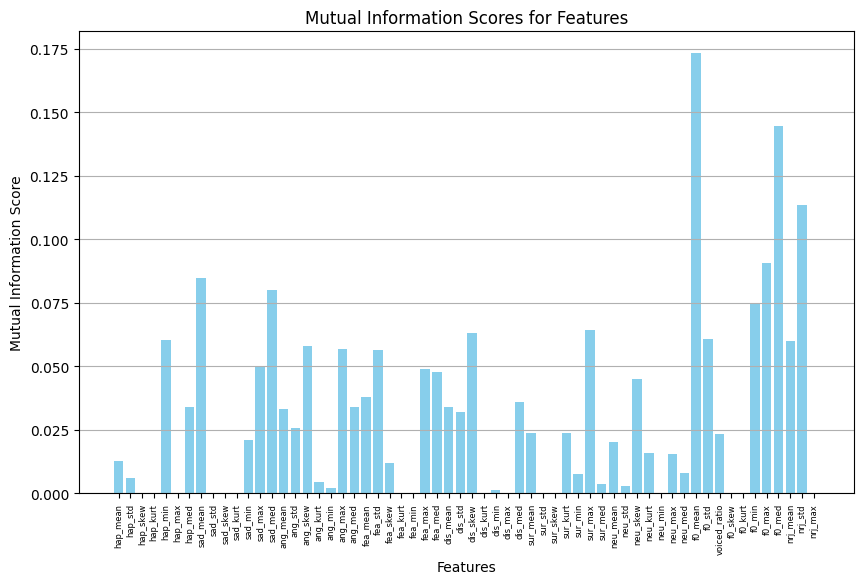

In [20]:
features = ['hap_mean', 'hap_std', 'hap_skew', 'hap_kurt', 'hap_min', 'hap_max', 'hap_med',
            'sad_mean', 'sad_std', 'sad_skew', 'sad_kurt', 'sad_min', 'sad_max', 'sad_med',
            'ang_mean', 'ang_std', 'ang_skew', 'ang_kurt', 'ang_min', 'ang_max', 'ang_med',
            'fea_mean', 'fea_std', 'fea_skew', 'fea_kurt', 'fea_min', 'fea_max', 'fea_med',
            'dis_mean', 'dis_std', 'dis_skew', 'dis_kurt', 'dis_min', 'dis_max', 'dis_med',
            'sur_mean', 'sur_std', 'sur_skew', 'sur_kurt', 'sur_min', 'sur_max', 'sur_med',
            'neu_mean', 'neu_std', 'neu_skew', 'neu_kurt', 'neu_min', 'neu_max', 'neu_med',
            'f0_mean', 'f0_std', 'voiced_ratio', 'f0_skew', 'f0_kurt', 'f0_min', 'f0_max', 'f0_med',
            'nrj_mean', 'nrj_std', 'nrj_max'
            ]

print(f"Number of features: {len(features)}")

get_mutual_information(X, Y, features, binary=False)

X shape: (195, 60), Y shape: (195,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


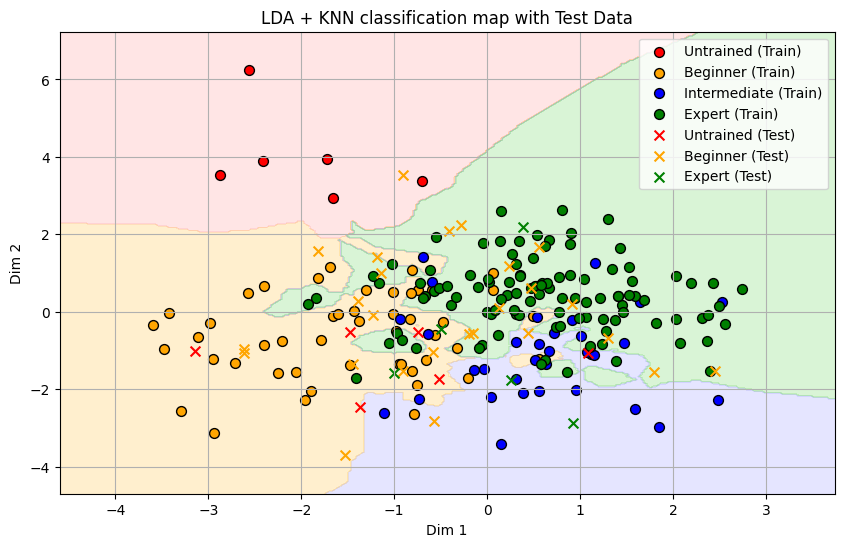

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 0 accuracy: 0.27
macro : {'precision': 0.15729166666666666, 'recall': 0.13653846153846155, 'f1-score': 0.13214285714285715, 'support': 37.0}
score detail : 10 / 37
X shape: (201, 60), Y shape: (201,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


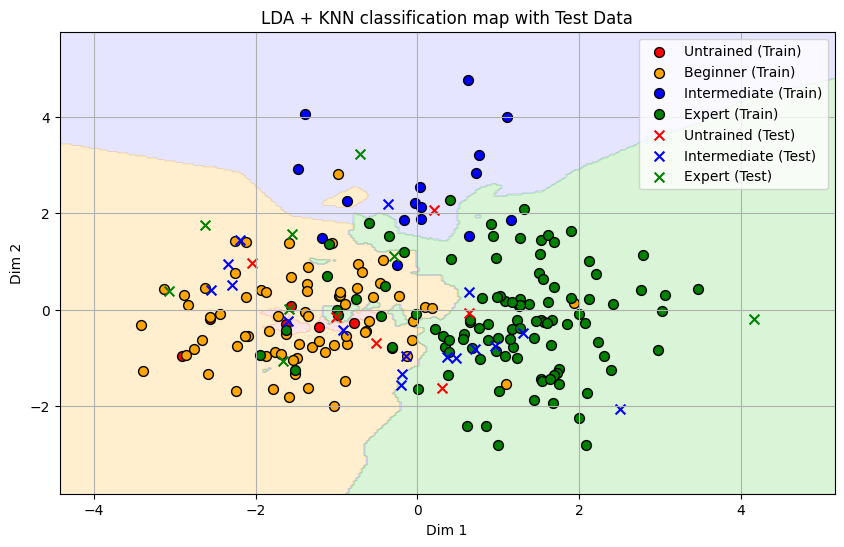

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 1 accuracy: 0.06
macro : {'precision': 0.10416666666666666, 'recall': 0.04595588235294118, 'f1-score': 0.05, 'support': 31.0}
score detail : 2 / 31
X shape: (195, 60), Y shape: (195,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


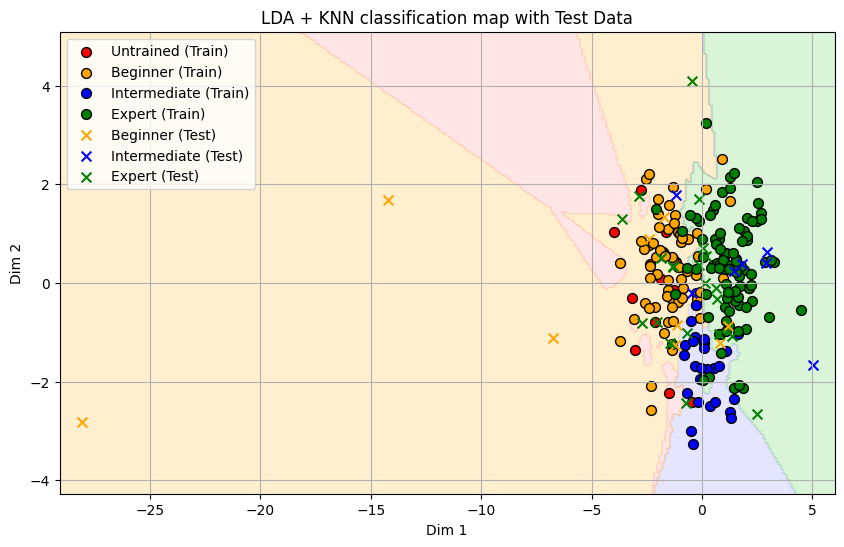

Fold 2 accuracy: 0.46
macro : {'precision': 0.3257080610021787, 'recall': 0.41798941798941797, 'f1-score': 0.34827810266406756, 'support': 37.0}
score detail : 17 / 37
X shape: (199, 60), Y shape: (199,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


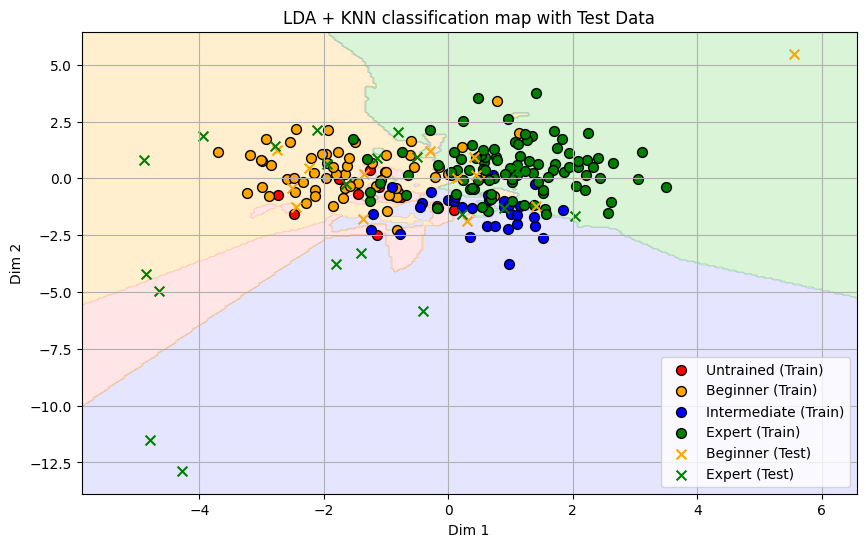

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 3 accuracy: 0.24
macro : {'precision': 0.1830357142857143, 'recall': 0.13365384615384615, 'f1-score': 0.14616402116402116, 'support': 33.0}
score detail : 8 / 33
X shape: (179, 60), Y shape: (179,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


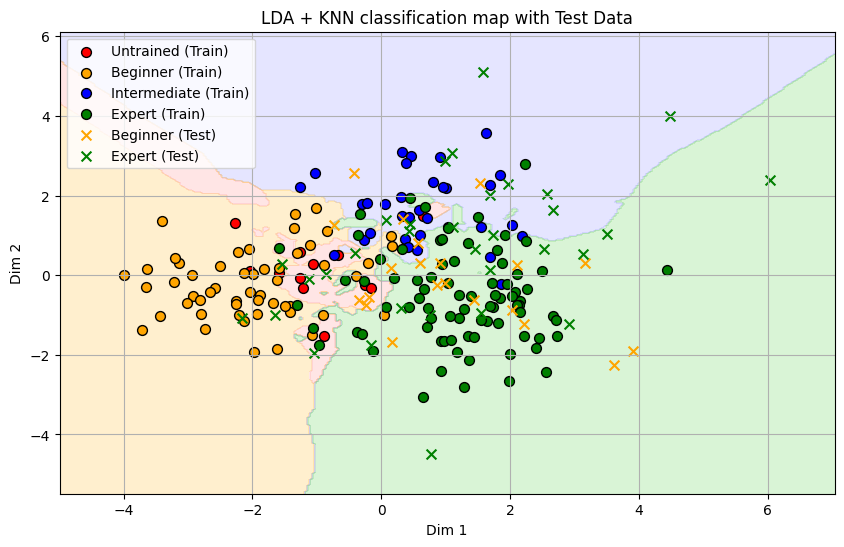

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 4 accuracy: 0.26
macro : {'precision': 0.125, 'recall': 0.109375, 'f1-score': 0.11666666666666667, 'support': 53.0}
score detail : 14 / 53
X shape: (191, 60), Y shape: (191,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


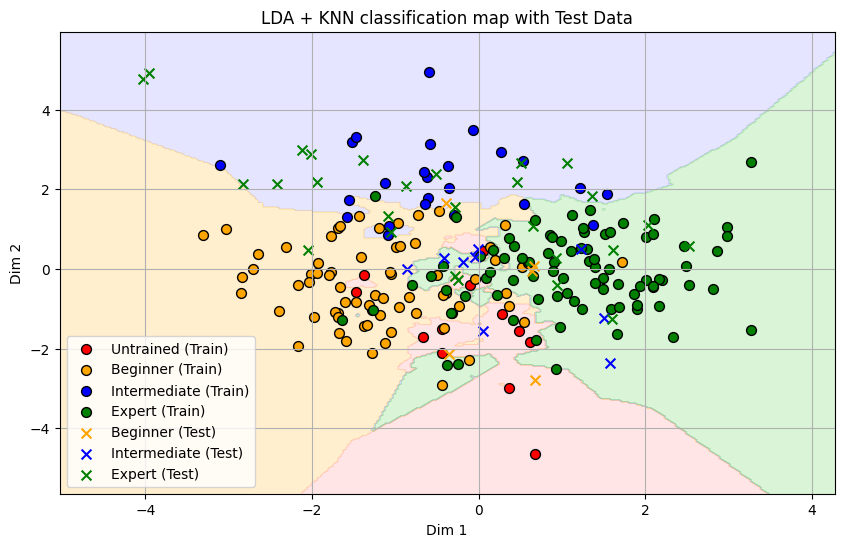

Fold 5 accuracy: 0.17
macro : {'precision': 0.125, 'recall': 0.06481481481481481, 'f1-score': 0.08536585365853659, 'support': 41.0}
score detail : 7 / 41
total accuracy : 58 / 232 = 0.25


/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

In [21]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 21
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

correct_guesses = 0
support = 0

for index, fold in enumerate(folds):
    train_fold, test_fold = fold

    X, Y = get_feature_vectors_fold(train_fold,
                                    metadata_filepath,
                                    emotion_model,
                                    task,
                                    analysis_duration,
                                    features_to_extract,
                                    pondered_outputs)

    X_test, Y_test = get_feature_vectors_fold(test_fold,
                                            metadata_filepath,
                                            emotion_model,
                                            task,
                                            analysis_duration,
                                            features_to_extract,
                                            pondered_outputs)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")

    X = X.fillna(0)
    X_test = X_test.fillna(0)

    ### LDA analysis
    X_lda, lda = lda_analysis(X, Y, n_components=2)
    X_test_lda = lda.transform(X_test)

    save_path = os.path.join('visualisations', 'time_invariant', f'{analysis_duration}s', f'fold_{index}.png')

    result = plot_knn_with_test_data(X_lda, Y, X_test_lda, Y_test, projection="LDA", save=save_path)
    accuracy_fold = result['classification_report']['accuracy']
    macro = result['classification_report']['macro avg']
    support_fold = round(macro['support'])
    correct_guess = round(accuracy_fold * support_fold)
    print(f"Fold {index} accuracy: {accuracy_fold:.2f}")
    print(f"macro : {macro}")
    print(f"score detail : {correct_guess} / {support_fold}")
    correct_guesses += correct_guess
    support += support_fold

total_accuracy = correct_guesses/support
print(f'total accuracy : {correct_guesses} / {support} = {total_accuracy}')


### 15 seconds analysis

In [22]:
### K-fold cross-validation

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert
labels = ['untrained'] * len(list_untrained) + ['beginner'] * len(list_beginner) + ['intermediate'] * len(list_intermediate) + ['expert'] * len(list_expert)

# create folds
folds = create_kfolds(all_individuals)

X shape: (325, 60), Y shape: (325,)


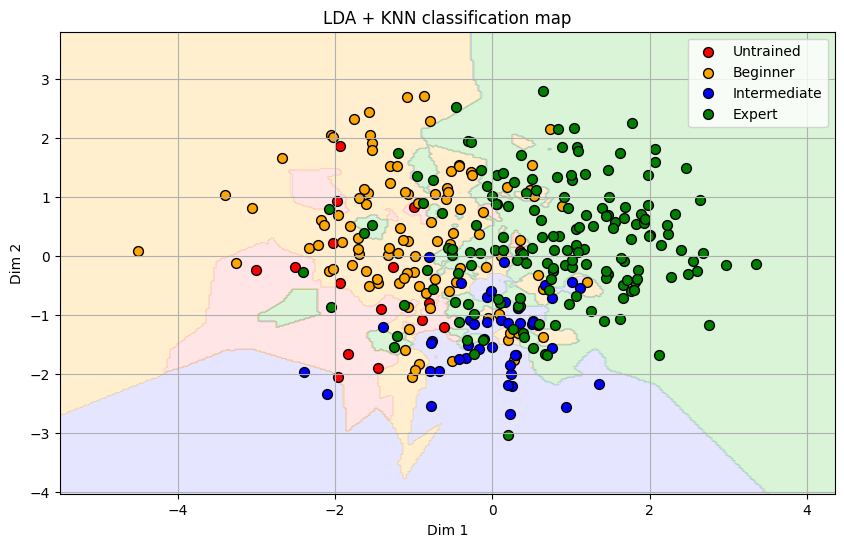

In [23]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 15
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

list_untrained = ['p002', 'p007']
list_beginner = ['p001', 'p003', 'p004', 'p005', 'p011', 'p014', 'p019', 'p020', 'p023']
list_intermediate = ['p009', 'p010', 'p017', 'p022']
list_expert = ['p006', 'p008', 'p012', 'p013', 'p015', 'p016', 'p018', 'p021']

all_individuals = list_untrained + list_beginner + list_intermediate + list_expert

X, Y = get_feature_vectors_fold(all_individuals,
                                metadata_filepath,
                                emotion_model,
                                task,
                                analysis_duration,
                                features_to_extract,
                                pondered_outputs)

X = X.fillna(0)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
# print(X)

# ### LDA analysis
X_lda, lda = lda_analysis(X, Y, n_components=2)

knn_lda = knn_multiclass_analysis(X_lda, Y, projection = "LDA")


Number of features: 60


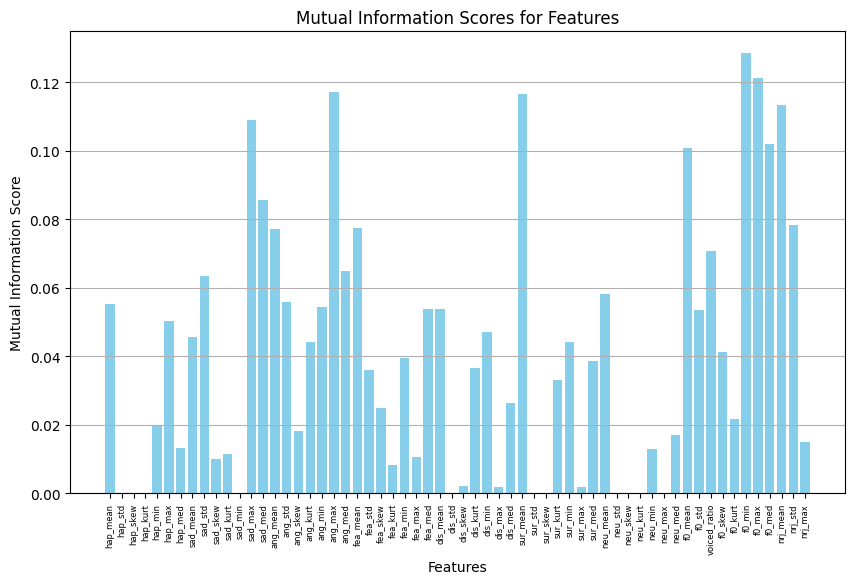

In [24]:
features = ['hap_mean', 'hap_std', 'hap_skew', 'hap_kurt', 'hap_min', 'hap_max', 'hap_med',
            'sad_mean', 'sad_std', 'sad_skew', 'sad_kurt', 'sad_min', 'sad_max', 'sad_med',
            'ang_mean', 'ang_std', 'ang_skew', 'ang_kurt', 'ang_min', 'ang_max', 'ang_med',
            'fea_mean', 'fea_std', 'fea_skew', 'fea_kurt', 'fea_min', 'fea_max', 'fea_med',
            'dis_mean', 'dis_std', 'dis_skew', 'dis_kurt', 'dis_min', 'dis_max', 'dis_med',
            'sur_mean', 'sur_std', 'sur_skew', 'sur_kurt', 'sur_min', 'sur_max', 'sur_med',
            'neu_mean', 'neu_std', 'neu_skew', 'neu_kurt', 'neu_min', 'neu_max', 'neu_med',
            'f0_mean', 'f0_std', 'voiced_ratio', 'f0_skew', 'f0_kurt', 'f0_min', 'f0_max', 'f0_med',
            'nrj_mean', 'nrj_std', 'nrj_max'
            ]

print(f"Number of features: {len(features)}")

get_mutual_information(X, Y, features, binary=False)

X shape: (274, 60), Y shape: (274,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


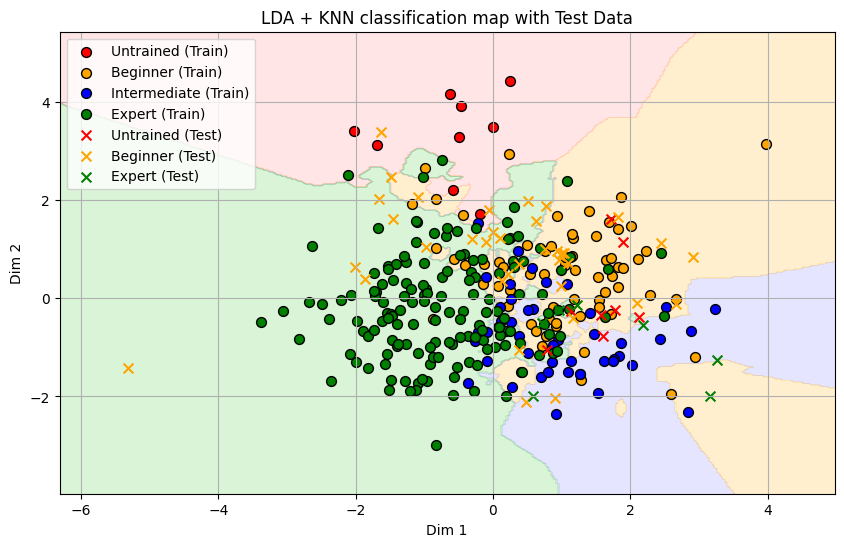

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 0 accuracy: 0.27
macro : {'precision': 0.14583333333333334, 'recall': 0.09722222222222222, 'f1-score': 0.11666666666666667, 'support': 51.0}
score detail : 14 / 51
X shape: (281, 60), Y shape: (281,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


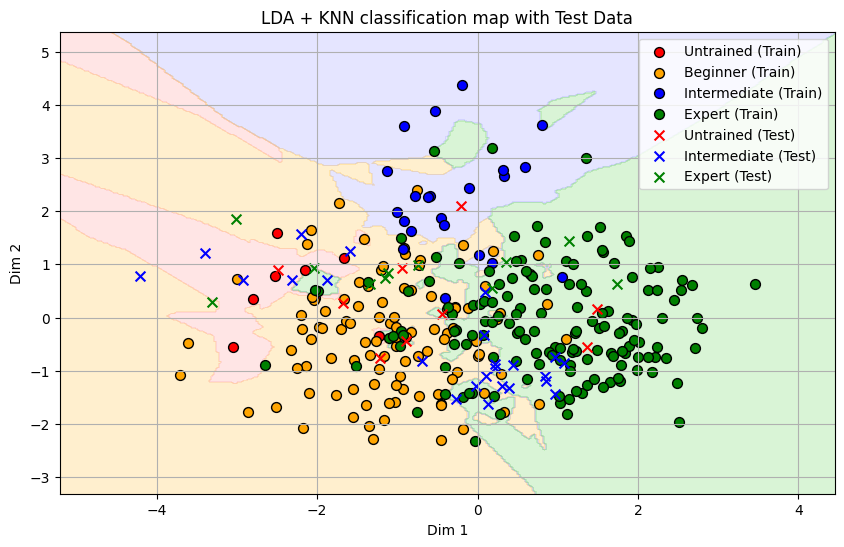

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 1 accuracy: 0.11
macro : {'precision': 0.09545454545454546, 'recall': 0.11868686868686869, 'f1-score': 0.09632034632034632, 'support': 44.0}
score detail : 5 / 44
X shape: (272, 60), Y shape: (272,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


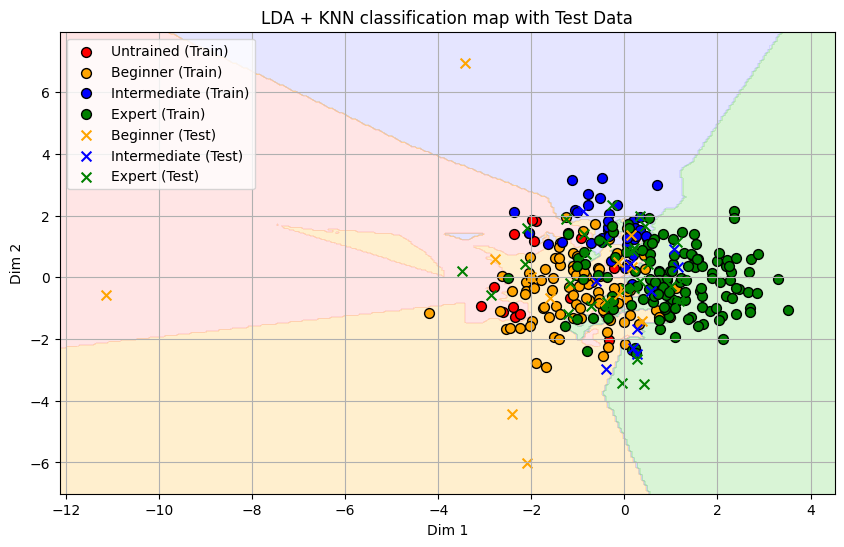

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 2 accuracy: 0.45
macro : {'precision': 0.33040935672514615, 'recall': 0.31474358974358974, 'f1-score': 0.3097979323308271, 'support': 53.0}
score detail : 24 / 53
X shape: (277, 60), Y shape: (277,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


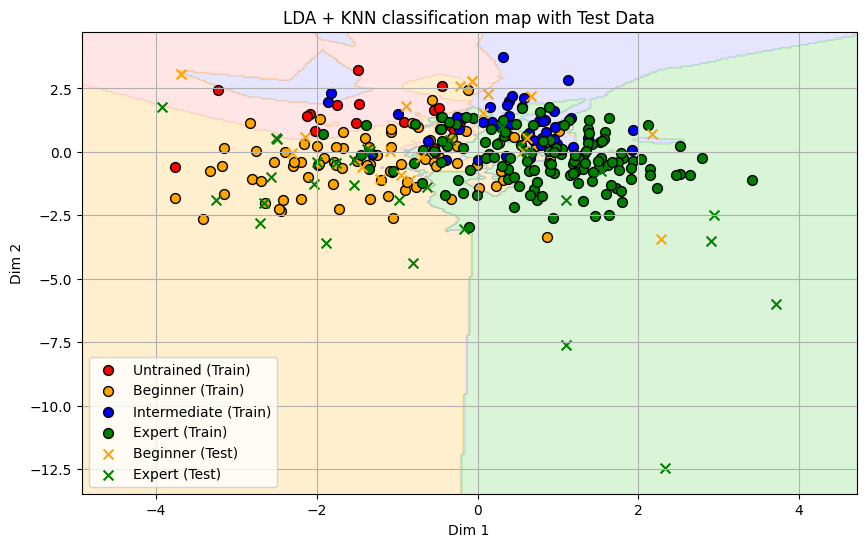

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 3 accuracy: 0.38
macro : {'precision': 0.2534340659340659, 'recall': 0.19600725952813067, 'f1-score': 0.20288753799392095, 'support': 48.0}
score detail : 18 / 48
X shape: (252, 60), Y shape: (252,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


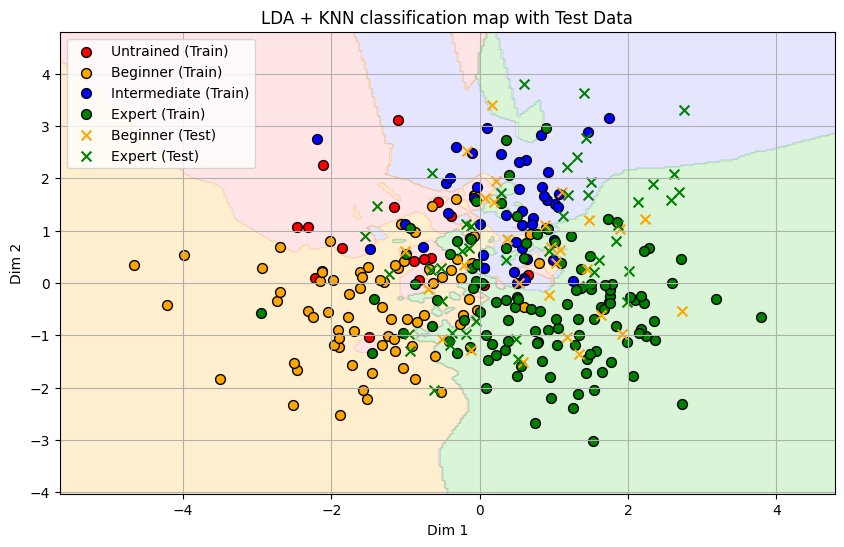

/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

Fold 4 accuracy: 0.33
macro : {'precision': 0.20833333333333334, 'recall': 0.14345238095238094, 'f1-score': 0.16712962962962963, 'support': 73.0}
score detail : 24 / 73
X shape: (269, 60), Y shape: (269,)


/tmp/ipykernel_2839522/1685790970.py:402: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_2D_test[mask, 0], X_2D_test[mask, 1],


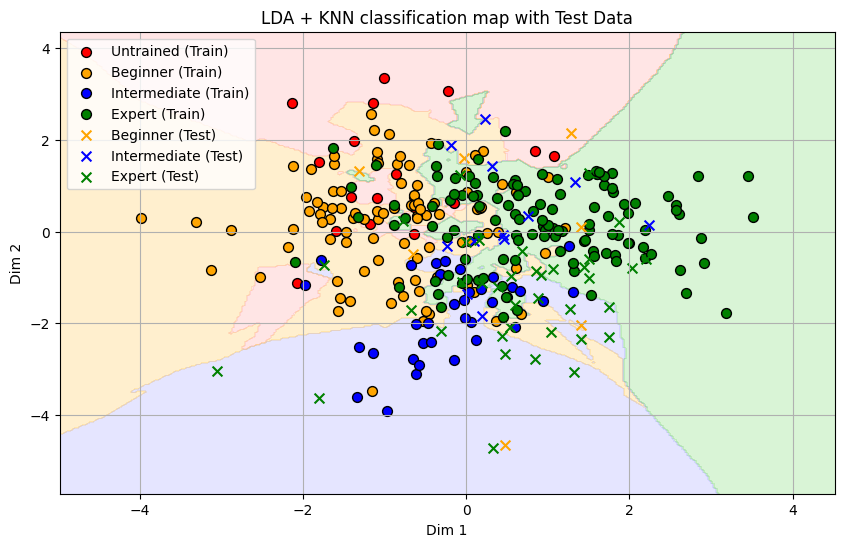

Fold 5 accuracy: 0.34
macro : {'precision': 0.2513157894736842, 'recall': 0.2434041184041184, 'f1-score': 0.22324690024180685, 'support': 56.0}
score detail : 19 / 56
total accuracy : 104 / 325 = 0.32


/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tnguyen/Documents/Emotion_recognition/Multimodal_Emotion_Recognition_for_Geriatric_Medecine/emotion_recognition_env/lib/python3.10/site-packages/s

In [25]:
metadata_filepath = os.path.join("data", "metadata_humanitude", "metadata_audio.csv")
emotion_model = "20250526-120449"
task = "boutonnage"
analysis_duration = 15
features_to_extract = ['emo', 'f0', 'nrj']
pondered_outputs = True

correct_guesses = 0
support = 0

for index, fold in enumerate(folds):
    train_fold, test_fold = fold

    X, Y = get_feature_vectors_fold(train_fold,
                                    metadata_filepath,
                                    emotion_model,
                                    task,
                                    analysis_duration,
                                    features_to_extract,
                                    pondered_outputs)

    X_test, Y_test = get_feature_vectors_fold(test_fold,
                                            metadata_filepath,
                                            emotion_model,
                                            task,
                                            analysis_duration,
                                            features_to_extract,
                                            pondered_outputs)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")

    X = X.fillna(0)
    X_test = X_test.fillna(0)

    ### LDA analysis
    X_lda, lda = lda_analysis(X, Y, n_components=2)
    X_test_lda = lda.transform(X_test)

    save_path = os.path.join('visualisations', 'time_invariant', f'{analysis_duration}s', f'fold_{index}.png')

    result = plot_knn_with_test_data(X_lda, Y, X_test_lda, Y_test, projection="LDA", save=save_path)
    accuracy_fold = result['classification_report']['accuracy']
    macro = result['classification_report']['macro avg']
    support_fold = round(macro['support'])
    correct_guess = round(accuracy_fold * support_fold)
    print(f"Fold {index} accuracy: {accuracy_fold:.2f}")
    print(f"macro : {macro}")
    print(f"score detail : {correct_guess} / {support_fold}")
    correct_guesses += correct_guess
    support += support_fold

total_accuracy = correct_guesses/support
print(f'total accuracy : {correct_guesses} / {support} = {total_accuracy}')
